<a href="https://colab.research.google.com/github/Patryk1212/VehicleClassifier/blob/master/Vehicle_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare dataset

Load Libraries

In [ ]:
%matplotlib inline
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

import cv2
import random
from sklearn.model_selection import train_test_split
import math

import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Unzip dataset from google drive

In [ ]:
!unzip '/content/gdrive/MyDrive/dataset/vehicles.zip' > /dev/null

Show specific image (for testing only)

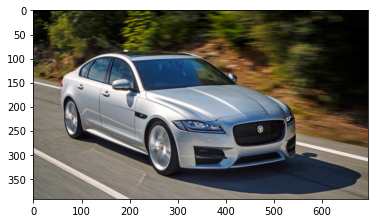

In [ ]:
image = mpimg.imread('vehicles/Learning/Car/car (21).jpg')
plt.imshow(image)
plt.show()

Set data into three directories and subdirectories

In [ ]:
base_dir = os.path.join(os.path.dirname("/content/vehicles"), 'vehicles')
train_dir = os.path.join(base_dir, 'Learning')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Testing')

In [ ]:
# directories with training pictures
train_car_dir = os.path.join(train_dir, 'Car')
train_lorry_dir = os.path.join(train_dir, 'Lorry')
train_suv_dir = os.path.join(train_dir, 'SUV')
train_van_dir = os.path.join(train_dir, 'Van')

# directories with validation pictures
validation_car_dir = os.path.join(validation_dir, 'Car')
validation_lorry_dir = os.path.join(validation_dir, 'Lorry')
validation_suv_dir = os.path.join(validation_dir, 'SUV')
validation_van_dir = os.path.join(validation_dir, 'Van')

# directories with testing pictures
test_car_dir = os.path.join(test_dir, 'Car')
test_lorry_dir = os.path.join(test_dir, 'Lorry')
test_suv_dir = os.path.join(test_dir, 'SUV')
test_van_dir = os.path.join(test_dir, 'Van')

Show number of images for each category and label

In [ ]:
# training

num_train_examples = len(os.listdir(train_car_dir)) + len(os.listdir(train_lorry_dir)) + len(os.listdir(train_suv_dir)) + len(os.listdir(train_van_dir))
print("Training data set,", num_train_examples, "in total. ")
print('- car images: ', len(os.listdir(train_car_dir)))
print('- lorry images: ', len(os.listdir(train_lorry_dir)))
print('- suv images: ', len(os.listdir(train_suv_dir)))
print('- van images: ', len(os.listdir(train_van_dir)))
print("")

# validation

num_valid_examples = len(os.listdir(validation_car_dir)) + len(os.listdir(validation_lorry_dir)) + len(os.listdir(validation_suv_dir)) + len(os.listdir(validation_van_dir))
print("Validation data set,", num_valid_examples, "in total. ")
print('- car images: ', len(os.listdir(validation_car_dir)))
print('- lorry images: ', len(os.listdir(validation_lorry_dir)))
print('- suv images: ', len(os.listdir(validation_suv_dir)))
print('- van images: ', len(os.listdir(validation_van_dir)))
print("")

# testing

num_test_examples = len(os.listdir(test_car_dir)) + len(os.listdir(test_lorry_dir)) + len(os.listdir(test_suv_dir)) + len(os.listdir(test_van_dir))
print("Test data set,", num_test_examples, "in total. ")
print('- car images: ', len(os.listdir(test_car_dir)))
print('- lorry images: ', len(os.listdir(test_lorry_dir)))
print('- suv images: ', len(os.listdir(test_suv_dir)))
print('- van images: ', len(os.listdir(test_van_dir)))
print("")

Training data set, 615 in total. 
- car images:  152
- lorry images:  157
- suv images:  145
- van images:  161

Validation data set, 86 in total. 
- car images:  21
- lorry images:  22
- suv images:  20
- van images:  23

Test data set, 174 in total. 
- car images:  43
- lorry images:  44
- suv images:  41
- van images:  46



# Setup Needed Variables and Functions

Variables

In [ ]:
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
BATCH_SIZE = 32
NUMBER_OF_CLASSES = 4

Functions to manipulate images for each dataset (data augmentation)

In [ ]:
image_gen_training = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

image_gen_validation = ImageDataGenerator(
    rescale=1./255
)

image_gen_testing = ImageDataGenerator(
    rescale=1./255
)

Functions for accuracy graphs

In [ ]:
import plotly.graph_objects as go
def accuracyGraphOne(history):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=history.epoch,
                           y=history.history['accuracy'],
                           mode='lines+markers',
                           name='Training accuracy'))
  fig.add_trace(go.Scatter(x=history.epoch,
                           y=history.history['val_accuracy'],
                           mode='lines+markers',
                           name='Validation accuracy'))
  fig.update_layout(title='Accuracy',
                    xaxis=dict(title='Epoch'),
                    yaxis=dict(title='Percentage'))
  fig.show()

In [ ]:
def accuracyGraphTwo(history, EPOCH_NUMBER):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCH_NUMBER)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

Displaying images function

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 3, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Model functions 

In [ ]:
def printTestSetResults(model, test_data):
  test_results = model.evaluate(test_data, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

# Main Model

Creating datasets from directories + applying changes to images (Data Augmentation, Size)

In [ ]:
train_data_gen = image_gen_training.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical')

validation_data_gen = image_gen_validation.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=validation_dir,
    shuffle=False,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical')

test_data_gen = image_gen_testing.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=test_dir,
    shuffle=False,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical')

Found 615 images belonging to 4 classes.
Found 86 images belonging to 4 classes.
Found 174 images belonging to 4 classes.


Display sample images

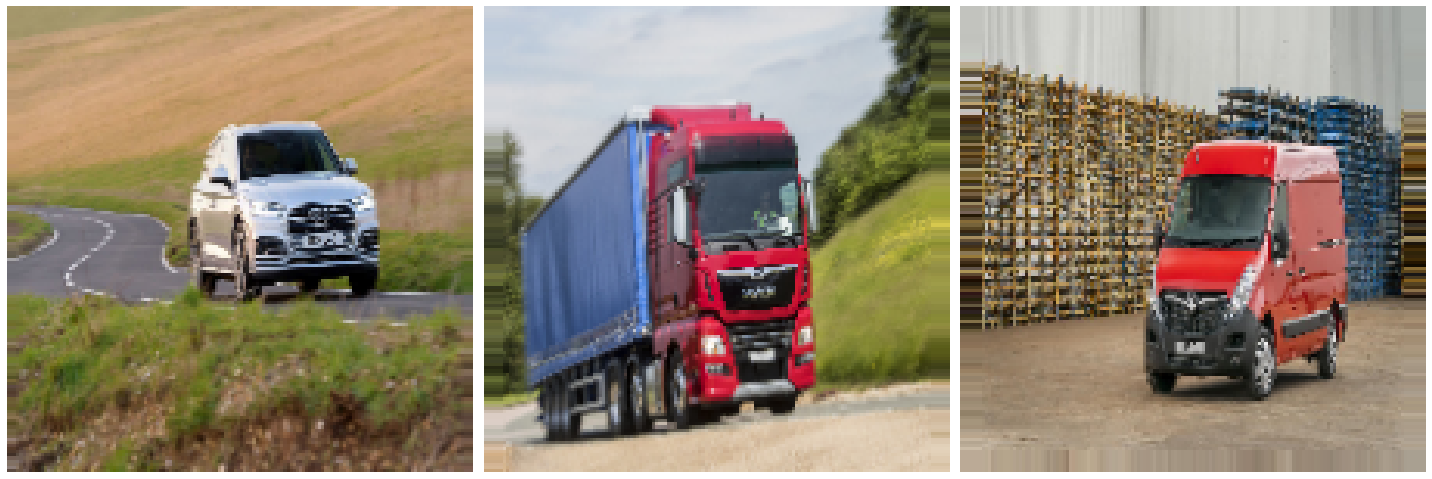

In [ ]:
sample_training_images, _ = next(train_data_gen)

plotImages(sample_training_images[:3])

Model creation

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', 
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUMBER_OF_CLASSES,  activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model information

In [ ]:
model.summary()

Model training

In [ ]:
EPOCH_NUMBER = 30

history = model.fit(train_data_gen, 
                    steps_per_epoch = num_train_examples // BATCH_SIZE,
                    epochs = EPOCH_NUMBER,
                    validation_data = validation_data_gen,
                    validation_steps = num_valid_examples // BATCH_SIZE,
                    #callbacks = [tf.keras.callbacks.EarlyStopping
                    #(
                    #monitor='val_loss',
                    #min_delta=0.01,
                    #patience=10
                    #)]
                    )

Epoch 1/30
 5/19 [======>.......................] - ETA: 13s - loss: 1.4000 - accuracy: 0.2381

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



19/19 [==============================] - 52s 1s/step - loss: 1.3945 - accuracy: 0.2411 - val_loss: 1.4500 - val_accuracy: 0.0312
Epoch 2/30
19/19 [==============================] - 23s 1s/step - loss: 1.3486 - accuracy: 0.3226 - val_loss: 1.4893 - val_accuracy: 0.3125
Epoch 3/30
19/19 [==============================] - 23s 1s/step - loss: 1.2837 - accuracy: 0.3659 - val_loss: 1.1585 - val_accuracy: 0.5312
Epoch 4/30
19/19 [==============================] - 23s 1s/step - loss: 1.2086 - accuracy: 0.4447 - val_loss: 1.3366 - val_accuracy: 0.1875
Epoch 5/30
19/19 [==============================] - 23s 1s/step - loss: 1.2396 - accuracy: 0.4179 - val_loss: 1.5732 - val_accuracy: 0.2969
Epoch 6/30
19/19 [==============================] - 23s 1s/step - loss: 1.1887 - accuracy: 0.4141 - val_loss: 1.0000 - val_accuracy: 0.5781
Epoch 7/30
19/19 [==============================] - 23s 1s/step - loss: 1.1365 - accuracy: 0.4459 - val_loss: 0.9928 - val_accuracy: 0.5938
Epoch 8/30
19/19 [=============

Show accuracy graph (1st option)

In [ ]:
accuracyGraphOne(history)

Show accuracy graph (2nd option)

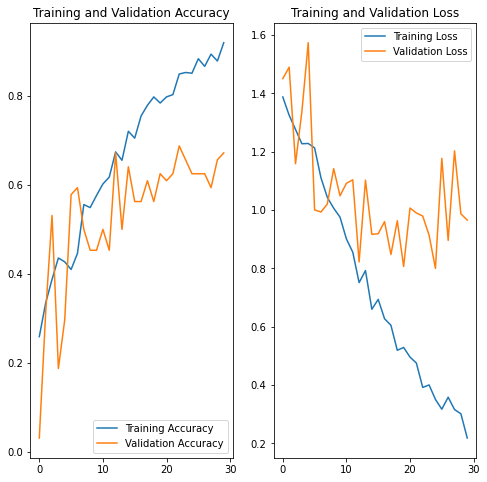

In [ ]:
accuracyGraphTwo(history, EPOCH_NUMBER)

Test trained model using test data

In [ ]:
printTestSetResults(model, test_data_gen)

6/6 [==============================] - 4s 606ms/step - loss: 1.1288 - accuracy: 0.6609
Test results - Loss: 1.1287888288497925 - Accuracy: 0.6609195470809937%


Save Model

In [ ]:
model.save('my_model.h5')

# Second Model (Transfer Learning)

Download and setup pre-trained model

In [ ]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
IMAGE_RES = 224

feature_extractor = hub.KerasLayer(CLASSIFIER_URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

feature_extractor.trainable = False

Prepare data

In [ ]:
new_train_data_gen = image_gen_training.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMAGE_RES, IMAGE_RES),
    class_mode='categorical')

new_validation_data_gen = image_gen_validation.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=validation_dir,
    shuffle=False,
    target_size=(IMAGE_RES, IMAGE_RES),
    class_mode='categorical')

new_test_data_gen = image_gen_testing.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=test_dir,
    shuffle=False,
    target_size=(IMAGE_RES, IMAGE_RES),
    class_mode='categorical')

Found 615 images belonging to 4 classes.
Found 86 images belonging to 4 classes.
Found 174 images belonging to 4 classes.


Model creation

In [ ]:
new_model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(NUMBER_OF_CLASSES)
])

Model information

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


Compile new model

In [ ]:
new_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model training

In [ ]:
EPOCH_NUMBER = 5

new_history = new_model.fit(new_train_data_gen, 
                    steps_per_epoch = num_train_examples // BATCH_SIZE,
                    epochs = EPOCH_NUMBER,
                    validation_data = new_validation_data_gen,
                    validation_steps = num_valid_examples // BATCH_SIZE
                    #callbacks = [tf.keras.callbacks.EarlyStopping
                    #(
                    #monitor='val_loss',
                    #min_delta=0.01,
                    #patience=10
                    #)]
                    )

Epoch 1/5
15/19 [======================>.......] - ETA: 4s - loss: 4.4250 - accuracy: 0.2642

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



19/19 [==============================] - 30s 1s/step - loss: 4.6924 - accuracy: 0.2635 - val_loss: 10.3257 - val_accuracy: 0.3438
Epoch 2/5
19/19 [==============================] - 26s 1s/step - loss: 10.8609 - accuracy: 0.2505 - val_loss: 10.3428 - val_accuracy: 0.3438
Epoch 3/5
19/19 [==============================] - 26s 1s/step - loss: 8.1555 - accuracy: 0.2365 - val_loss: 10.3486 - val_accuracy: 0.2031
Epoch 4/5
19/19 [==============================] - 26s 1s/step - loss: 7.8973 - accuracy: 0.4347 - val_loss: 11.8400 - val_accuracy: 0.1406
Epoch 5/5
19/19 [==============================] - 26s 1s/step - loss: 9.5592 - accuracy: 0.4034 - val_loss: 12.0903 - val_accuracy: 0.1406


Show both accuracy graphs

In [ ]:
accuracyGraphOne(new_history)

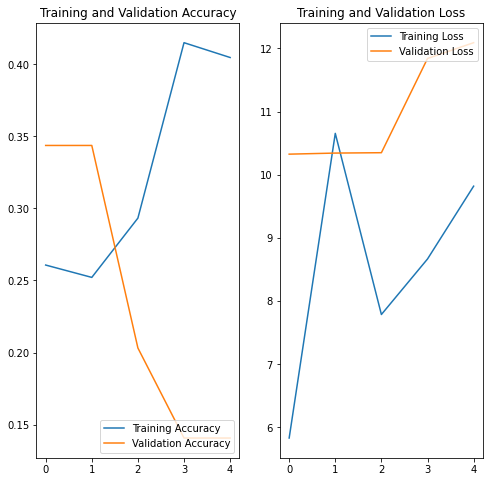

In [ ]:
accuracyGraphTwo(new_history, EPOCH_NUMBER)

Test trained model using test data

In [ ]:
printTestSetResults(new_model, new_test_data_gen)

6/6 [==============================] - 4s 624ms/step - loss: 9.7264 - accuracy: 0.3678
Test results - Loss: 9.726436614990234 - Accuracy: 0.36781609058380127%


# Visual representation

In [ ]:

# functions for gradcam
# https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


last_conv_layer_name = "dropout"
classifier_layer_names = [
    "dense",
    "dense_1",
    "dense_2",
    "dense_3",
    "dense_4",
]

#"conv2d",
#    "max_pooling2d",
#    "conv2d_1",
#    "max_pooling2d_1",
#    "conv2d_2",
#    "max_pooling2d_2",
#    "conv2d_3",
#    "max_pooling2d_3",
#    "dropout",
#    "flatten",
#    "dense",
#    "dense_1",
#    "dense_2",
#    "dense_3",
#    "dense_4"

# show heatmaps
plt.figure(figsize=(20, 20))
plt.suptitle("Heatmaps for testing batch", fontweight='bold')
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n + 1)
    array = sample_training_images[:n]#keras.preprocessing.image.img_to_array(test_images[n])
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    plt.imshow(make_gradcam_heatmap(array, model, last_conv_layer_name, classifier_layer_names))
    label = class_names[test_labels[n].numpy()]
    if label == predicted_label_batch[n]:
        plt.title(predicted_label_batch[n].title(), color="green")
    else:
        plt.title(predicted_label_batch[n].title() + " (" + label + ")", color="red")
    plt.axis('off')


plt.show()


def create_superimposed_img(heatmap, image):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image * 255
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img


# show superimposed images
plt.figure(figsize=(20, 20))
plt.suptitle("Superimposed images for testing batch", fontweight='bold')
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n + 1)
    array = keras.preprocessing.image.img_to_array(test_images[n])
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    heatmap = make_gradcam_heatmap(array, classifier_model, last_conv_layer_name, classifier_layer_names)
    plt.imshow(create_superimposed_img(heatmap, test_images[n]))
    label = class_names[test_labels[n].numpy()]
    if label == predicted_label_batch[n]:
        plt.title(predicted_label_batch[n].title(), color="green")
    else:
        plt.title(predicted_label_batch[n].title() + " (" + label + ")", color="red")
    plt.axis('off')

plt.show()